In [1]:
# install required packages for the project
!pip install -q scikit-learn pandas numpy imbalanced-learn matplotlib seaborn joblib shap


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# imports + load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import joblib

pd.set_option('display.max_columns', None)
print("pandas, sklearn, imblearn versions:", pd.__version__)
# Load dataset - change path if needed
df = pd.read_csv("creditcard.csv")
print("Loaded shape:", df.shape)
print("Class distribution (counts):\n", df['Class'].value_counts())
print("Class distribution (proportions):\n", df['Class'].value_counts(normalize=True))
print(df.head())


pandas, sklearn, imblearn versions: 2.3.3
Loaded shape: (284807, 31)
Class distribution (counts):
 Class
0    284315
1       492
Name: count, dtype: int64
Class distribution (proportions):
 Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
2  0.247676 -1.514654  0.207643

In [3]:
# cleaning + checks
print("Missing values per column:\n", df.isnull().sum().sort_values(ascending=False).head(20))
# If missing are negligible, drop them:
df = df.dropna().reset_index(drop=True)
print("After dropna shape:", df.shape)


Missing values per column:
 Time    0
V1      0
V2      0
V3      0
V4      0
V5      0
V6      0
V7      0
V8      0
V9      0
V10     0
V11     0
V12     0
V13     0
V14     0
V15     0
V16     0
V17     0
V18     0
V19     0
dtype: int64
After dropna shape: (284807, 31)


In [ ]:
# simulate behavior features (deterministic seed for reproducibility)
np.random.seed(42)
n = df.shape[0]

# Simulate user_id: adjust n_users as desired
n_users = 5000
df['user_id'] = np.random.choice(np.arange(n_users), size=n)

# Stimulate device category distribution
df['device'] = np.random.choice(['mobile','desktop','tablet'], size=n, p=[0.6,0.35,0.05])

# Simulate login_hour (0-23). Optionally correlate fraud with late-night hours later.
df['login_hour'] = np.random.randint(0,24,size=n)

# Aggregate per user: user_total_tx
user_counts = df['user_id'].value_counts().rename('user_total_tx')
df = df.merge(user_counts, left_on='user_id', right_index=True)

# session_count_24h: simulate based on user_total_tx
df['session_count_24h'] = (np.random.poisson(1, size=n) + (df['user_total_tx'] > 5).astype(int))

# device_change_count: small poisson noise + occasional changes
df['device_change_count'] = np.random.poisson(0.2, size=n) + (np.random.rand(n) < 0.05).astype(int)

print("Sample of behavioral columns:\n", df[['user_id','device','login_hour','user_total_tx','session_count_24h','device_change_count']].head())


Sample of behavioral columns:
    user_id   device  login_hour  user_total_tx  session_count_24h  \
0      860  desktop           4             52                  1   
1     3772   mobile          16             50                  1   
2     3092   mobile          18             62                  2   
3      466   tablet           5             52                  2   
4     4426  desktop          15             58                  1   

   device_change_count  
0                    0  
1                    0  
2                    0  
3                    0  
4                    1  


In [5]:
# encode categorical features
# One-hot for device
df = pd.get_dummies(df, columns=['device'], drop_first=True)

# Label encode user_id for tree models (for sequence models we'll treat differently)
le = LabelEncoder()
df['user_id_enc'] = le.fit_transform(df['user_id'])

# build features list (V1..V28, Time, Amount + behavioral features)
features = [f"V{i}" for i in range(1,29)] + ['Time','Amount',
            'session_count_24h','device_change_count','login_hour',
            'device_desktop','device_tablet','user_id_enc']

# keep only available cols to avoid errors
features = [c for c in features if c in df.columns]
print("Number of features selected:", len(features))
print("First 20 features:", features[:20])
X = df[features]
y = df['Class'].astype(int)
print("Feature matrix shape:", X.shape, "Target shape:", y.shape)


Number of features selected: 35
First 20 features: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20']
Feature matrix shape: (284807, 35) Target shape: (284807,)


In [6]:
# scale Time and Amount
scaler = StandardScaler()
to_scale = [c for c in ['Time','Amount'] if c in X.columns]
if to_scale:
    X[to_scale] = scaler.fit_transform(X[to_scale])
    print("Scaled columns:", to_scale)
else:
    print("No Time/Amount found to scale.")
# Optionally persist scaler after training

Scaled columns: ['Time', 'Amount']


C:\Users\Shashwat\AppData\Local\Temp\ipykernel_23348\2685350633.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[to_scale] = scaler.fit_transform(X[to_scale])


In [9]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class ratio:", y_train.mean(), "Test class ratio:", y_test.mean())


Train shape: (227845, 35) Test shape: (56962, 35)
Train class ratio: 0.001729245759178389 Test class ratio: 0.0017204452090867595


In [10]:
# Sampling strategy toggle
USE_SMOTE = False   # <-- set True to use SMOTE oversampling (may increase memory/time)
SMOTE_PROPORTION = 0.1  # if SMOTE, minority will be this fraction of majority (0.1 = 10%)

if USE_SMOTE:
    print("Using SMOTE. This may increase dataset size.")
    sm = SMOTE(sampling_strategy=SMOTE_PROPORTION, random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    print("After SMOTE, X_train_res shape:", X_train_res.shape, "pos ratio:", y_train_res.mean())
else:
    print("Using class_weight='balanced' (no resampling).")
    X_train_res, y_train_res = X_train, y_train


Using class_weight='balanced' (no resampling).


Training RandomForest...
Training done.
Classification report:
               precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56864
           1     0.9610    0.7551    0.8457        98

    accuracy                         0.9995     56962
   macro avg     0.9803    0.8775    0.9227     56962
weighted avg     0.9995    0.9995    0.9995     56962

Confusion matrix:
 [[56861     3]
 [   24    74]]
ROC AUC: 0.9572128953579181


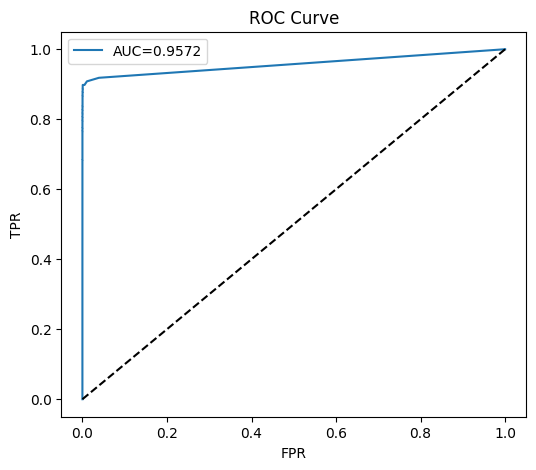

In [12]:
# train & evaluate
clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced' if not USE_SMOTE else None
)

print("Training RandomForest...")
clf.fit(X_train_res, y_train_res)
print("Training done.")

# Predictions and metrics
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print("Classification report:\n", classification_report(y_test, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# ROC plot
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test,y_proba):.4f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend()
plt.show()


Top 20 features:
 V14       0.136309
V10       0.104287
V4        0.097548
V17       0.093501
V3        0.081379
V12       0.079751
V11       0.055885
V16       0.053644
V7        0.039714
V2        0.035035
V9        0.025015
V18       0.018469
V21       0.016940
V19       0.014929
V20       0.014013
V6        0.013486
Amount    0.013182
V27       0.011325
V1        0.011322
V8        0.011065
dtype: float64


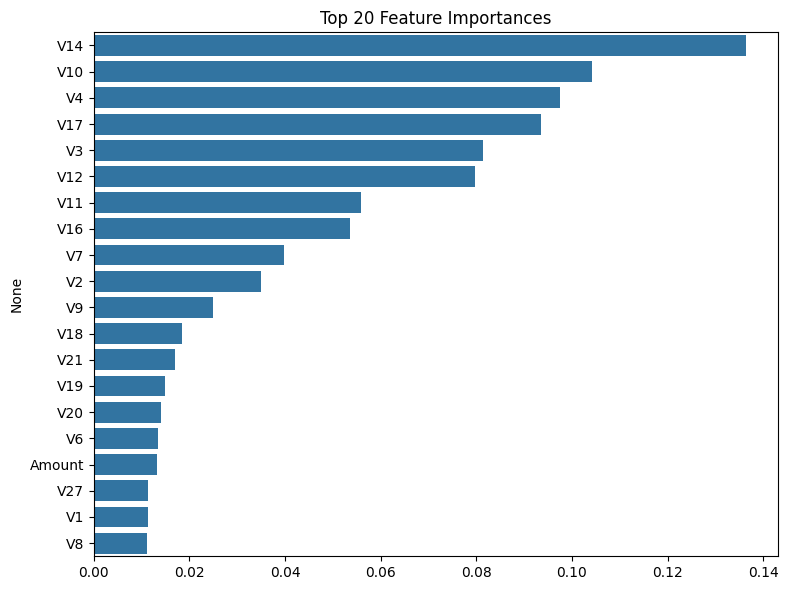

Saved rf_fraud_model.joblib and scaler_Time_Amount.joblib


In [14]:
# feature importance + save artifacts
importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top 20 features:\n", importances.head(20))

# Plot top 20
plt.figure(figsize=(8,6))
sns.barplot(x=importances.head(20).values, y=importances.head(20).index)
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.show()

# Save model & scaler
joblib.dump(clf, "rf_fraud_model.joblib")
joblib.dump(scaler, "scaler_Time_Amount.joblib")
print("Saved rf_fraud_model.joblib and scaler_Time_Amount.joblib")


In [15]:
# inspect mistakes
df_test = X_test.copy()
df_test['y_true'] = y_test.values
df_test['y_pred'] = y_pred
df_test['y_proba'] = y_proba

fn = df_test[(df_test['y_true']==1) & (df_test['y_pred']==0)]
fp = df_test[(df_test['y_true']==0) & (df_test['y_pred']==1)]
print("False negatives (count):", len(fn))
print("False positives (count):", len(fp))
display(fn.head(5))
display(fp.head(5))


False negatives (count): 24
False positives (count): 3


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Time,Amount,session_count_24h,device_change_count,login_hour,device_tablet,user_id_enc,y_true,y_pred,y_proba
48094,-1.278138,0.716242,-1.143279,0.217805,-1.293890,-1.168952,-2.564182,0.204532,-1.611155,-1.250286,3.367361,-4.583096,-0.806940,-5.208305,0.525824,-1.815914,-5.249111,-2.196691,2.109053,0.817203,0.490183,0.470427,-0.126261,-0.126644,-0.661908,-0.349793,0.454851,0.137843,-1.080690,-0.253677,2,1,0,False,3786,1,0,0.400
70589,-2.042608,1.573578,-2.372652,-0.572676,-2.097353,-0.174142,-3.039520,-1.634233,-0.594809,-5.459602,2.378537,-2.330271,-0.246233,-4.058523,-0.316983,-2.522661,-5.603400,-0.778440,0.860212,0.825566,-0.723326,0.501222,-0.696892,-0.600514,0.127547,-0.786072,0.606097,0.171697,-0.860782,0.693749,3,0,6,False,2227,1,0,0.330
14170,-15.903635,10.393917,-19.133602,6.185969,-12.538021,-4.027030,-13.897827,10.662252,-2.844954,-9.668789,7.394419,-11.635630,1.423277,-8.640459,-0.674720,-7.695569,-13.684140,-4.777406,1.268343,1.501565,1.577548,-1.280137,-0.601295,0.040404,0.995502,-0.273743,1.688136,0.527831,-1.465965,0.046539,3,0,12,False,4316,1,0,0.270
8972,-4.064005,3.100935,-1.188498,3.264633,-1.903562,0.320351,-0.954940,-3.277535,2.820829,1.015113,3.187187,-7.004327,0.872711,-6.220605,-0.904445,-3.075092,-5.044736,-1.718083,-0.662462,-0.531898,1.688665,-0.078845,0.193731,0.479496,-0.506603,-0.409863,-3.036271,-0.630605,-1.735612,0.365067,1,0,21,False,559,1,0,0.180
152019,-3.705856,4.107873,-3.803656,1.710314,-3.582466,1.469729,-9.621560,-11.913105,-0.322297,-6.625692,2.175230,-4.381078,2.063299,-0.673818,1.400763,-4.254927,-5.160213,-1.302526,2.594453,3.639603,-5.498772,2.941475,0.916236,-0.255504,-0.183835,-0.584539,-0.315484,-0.097223,0.040076,-0.349231,2,0,0,False,3294,1,0,0.395


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Time,Amount,session_count_24h,device_change_count,login_hour,device_tablet,user_id_enc,y_true,y_pred,y_proba
190263,-1.272117,1.827615,-3.810610,0.583759,-0.641242,-1.389043,-1.954054,1.173920,-2.053191,-3.345061,2.376404,-2.538052,-0.090454,-2.426168,-1.618648,-3.515944,-6.199008,-2.410606,0.760435,-0.027268,0.858998,0.858775,0.083079,0.741676,-0.173234,0.534870,0.183562,0.020316,0.714814,-0.350191,2,0,0,False,1954,0,1,0.645
14920,-17.950631,11.067069,-20.742660,6.075531,-13.389765,-4.532888,-15.188146,12.101062,-4.026880,-9.017413,6.070650,-8.567865,-0.001900,-9.301233,0.019796,-7.352120,-13.923225,-4.988304,1.347656,1.712909,1.797134,-1.275675,-0.705046,0.102040,1.177477,-0.238730,1.554463,0.547948,-1.444507,-0.349231,2,0,0,False,1628,0,1,0.885
16110,-26.619952,14.845545,-27.747084,6.408105,-19.025741,-5.053209,-19.041960,17.573712,-3.695863,-8.098048,4.524322,-6.314800,0.983251,-6.052126,-0.099910,-5.772456,-11.881960,-4.744603,0.809988,1.840055,1.853209,-1.985567,-1.210123,0.150261,1.879262,-0.225019,1.257380,0.451777,-1.416985,-0.349231,2,3,18,False,3436,0,1,0.790


c:\Users\Shashwat\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Accuracy: 99.95%
False Negative (FN)%: 16.33%
False Positive (FP)%: 0.03%
Recall%: 83.67%
Precision%: 84.54%
F1%: 84.10%


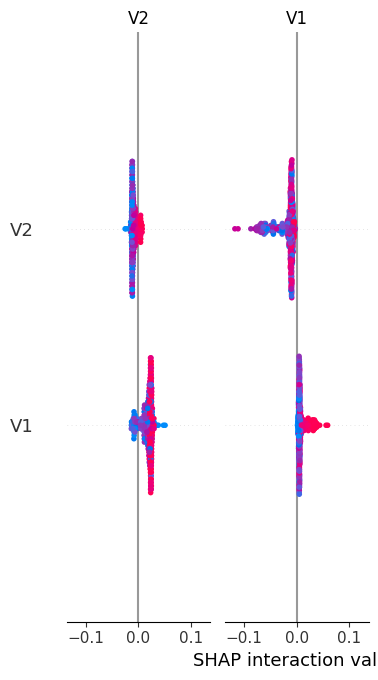

In [16]:
# ------------------- Final Evaluation + SHAP Block -------------------
import numpy as np
import shap
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import warnings
warnings.filterwarnings("ignore")

# --------- 1. Prediction on full test set ---------
best_threshold = 0.2  # adjust threshold to reduce FN
y_proba = clf.predict_proba(X_test)[:,1]
y_pred_final = (y_proba >= best_threshold).astype(int)

# --------- 2. Confusion Matrix & Metrics ---------
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_final).ravel()

accuracy = (tp+tn)/(tp+tn+fp+fn) * 100
fn_percent = (fn / (tp+fn)) * 100
fp_percent = (fp / (tn+fp)) * 100
recall = (tp / (tp+fn)) * 100
precision = (tp / (tp+fp)) * 100 if (tp+fp) > 0 else 0
f1_percent = f1_score(y_test, y_pred_final) * 100

print(f"Accuracy: {accuracy:.2f}%")
print(f"False Negative (FN)%: {fn_percent:.2f}%")
print(f"False Positive (FP)%: {fp_percent:.2f}%")
print(f"Recall%: {recall:.2f}%")
print(f"Precision%: {precision:.2f}%")
print(f"F1%: {f1_percent:.2f}%")

# --------- 3. SHAP Summary Plot (sampled) ---------
SAMPLE_SIZE = 500  # reduce for speed
TARGET_CLASS_INDEX = 1  # fraud class

X_shap = X_test.sample(n=min(SAMPLE_SIZE, len(X_test)), random_state=42)
X_shap = X_shap[X.columns]  # ensure same feature order

explainer = shap.TreeExplainer(clf)
shap_values_raw = explainer.shap_values(X_shap)

# Robust extraction of SHAP array for target class
def get_shap_array(raw, n_samples, n_features, target_class_idx=TARGET_CLASS_INDEX):
    if isinstance(raw, list):
        return np.array(raw[target_class_idx])
    return np.array(raw)

sv = get_shap_array(shap_values_raw, X_shap.shape[0], X_shap.shape[1], TARGET_CLASS_INDEX)

# Plot SHAP summary
shap.summary_plot(sv, X_shap)
